<h1 align = "Center"> IST 5520 Spring 2020: Group 1 Project Proposal </h1>
<h2 align = "Center"> An Analysis of Vermont Crashes Data</h2>
<h3 align = "Center"> By: Bryce Cordry, Kyle Johnson, Matthew Kovar, Yitian Luo, Brian Middleton </h3>

# Introduction

Traffic crashes happen every day in the world and they rank as the 9th leading cause of death. In the United States, there are an average of 16,438 car accidents per day. Moreover, nearly 1.25 million people die in car accidents per year, by this we mean that, car accidents cause 3,287 deaths per day. （https://www.thewanderingrv.com/car-accident-statistics/) Therefore, it is important for us to get more information about car crashes and try to avoid them.

We found a dataset of car crashes in the State of Vermont from the year 2014 to 2018. We are considering the dataset from the perspective of an insurance company using telematics devices in vehicles to create individualized risk profiles for policyholders located in Vermont and set their premiums accordingly. We are interested in determining what kinds of characteristics are responsible for vehicle accidents and how to use this information to adjust a policyholder's future premium once they are in an accident. To be more specific, we want to figure out what matters the most in the accidents. Also, we hope to find out factors that lead to various outcomes (property damage, injury or fatal). In addition, we want to find out areas or roads that are most prone to accidents.

# Data Source and Collection

The dataset was downloaded from the Vermont Open Geodata Portal (https://geodata.vermont.gov/datasets/VTrans::vt-crashes-2018?orderBy=ACCIDENTDATE&orderByAsc=false). 
We combined the data from year 2014 to year 2018 and it contains 61,562 car accidents in Vermont. The data was collected by various reporting agencies within Vermont. 

This dataset contains 36 columns listed below. Some of the key information includes the type of injury, the impairment of the driver, the accident location, date, weather, the road conditions, as well as the reporting agency. All of this information can be useful for us in determining how the insured's future premiums will be adjusted.
 

- 	OBJECTID 
-   REPORTINGAGENCYid 
- 	ReportingAgency 
- 	REPORTNUMBER 
- 	ACCIDENTDATE 
- 	STREETADDRESS 
- 	INTERSECTIONWITH 
- 	DirOfCollision 
- 	RoadGroup 
- 	AOTACTUALMILEPOINT 
- 	RoadCharacteristics 
- 	NonReportableAddress 
- 	CITYORTOWNid 
- 	CITYORTOWN 
- 	EASTING 
- 	NORTHING
- 	AOTROUTEid 
-	AOTROUTE 
-	LRSNUMBER 
-	HOWMAPPED 
-	Animal 
-	Impairment 
-	Involving 
-	Weather 
-	DayNight 
-	InjuryType 
-	LOC_ERROR 
-	RDFLNAME 
-	SurfaceCondition 
-	RoadCondition 
-	Route 
-	LATITUDE 
-	LONGITUDE 
-	AOTROADWAYGROUPid 


# Business Questions

After understanding where the data comes from and what it includes, we are able to simplify our business questions down to the following:

    1.Which factors cause accidents?
    2.Which factors best determine the outcome of an accident
    3.Which roads are most prone to accidents, and how can we improve them?

# Technical Approach

### Data Manipulation

Use Pandas/Numpy/Scipy for datasets manipulation. First we merge the datasets from the years 2015-2018. Some columns are dropped due to inconsistent recording from year to year. (Some columns don't exist on certain years). They we remove columns which hold data which is not relevant to our analysis, such as internal Vermonet Department of Transportation ID codes posted to cities for which we already have the names. Then we begin handling NA's by replacing them with a filler value such as "Unknown" where it is appropriate. Following that, we fill NA values based upon the general distribution of known values (where appropriate). Where possible we try to intelligently fill NA's by using clues in the data, such as on Road and Surface Conditions, we fill NA's by the prevalent weather first, and distribution second. Finally we remove rows with remaining NA's and save the cleansed data.   

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import and clean data, deal with missing values
years = [2015, 2016, 2017, 2018]
df_dict = {year:pd.read_csv("VT_Crashes__{}.csv".format(str(year))) for year in years}

for year, df in df_dict.items():
  df_dict[year] = df.rename(columns={"ACCIDENTDA":"ACCIDENTDATE", 
                                     "AOTACTUALM":"AOTACTUALMILEPOINT",
                                     "INTERSECTI":"INTERSECTIONWITH",
                                     "STREETADDR":"STREETADDRESS",
                                     "REPORTNUMB":"REPORTNUMBER",
                                     "ReportingAgency":"REPORTINGAGENCY",
                                     "DirOfCollision":"DIROFCOLLI",
                                     "VCSG_LRSNUMBER":"LRSNUMBER",
                                     "REPORTINGA":"REPORTINGAGENCYid",
                                     "VCSG_EASTING":"EASTING",
                                     "VCSG_NORTHING":"NORTHING",
                                     "VCSG_AOTROUTE":"AOTROUTE",
                                     "VCSG_CITYORTOWN":"CITYORTOWN"})
  df_dict[year]["Year"] = year

df_dict[2018] = df_dict[2018].rename(columns={"LATITUDE":"LAT_DD","LONGITUDE":"LONG_DD"})
df_dict[2017] = df_dict[2017].rename(columns={"GIS_LATITUDE":"LAT_DD","GIS_LONGITUDE":"LONG_DD"})

df = pd.concat(df_dict.values(), sort=True)

#Drop Columns
df = df.drop(columns=['ACCIDENTTI','AOTROADWAYGROUPid','AOTROUTEid','CITYORTOWNid','MILEMARKER1','MILEMARKER_1',
                      'MILEMARKER_2','NUMBER','NUMBER1','NUMBER2','NUMBER3','OBJECTID','RDFLNAME','REPORTINGAGENCYid',
                      'VCSG_AOTROUTEid','VCSG_CITYORTOWNid','NORTHING','EASTING','DIRFROMNEA','CrashType',
                     'DISTANCE_1','POSTEDSPEE','VCSG_LATITUDE','VCSG_LONGITUDE','Route', 'AOTROADWAY'])

#Merge categories in Involving column
df.replace(['Motorcyle'],['Motorcycle'], inplace = True)

#Relabel NA's
df['AOTACTUALMILEPOINT'] = df['AOTACTUALMILEPOINT'].fillna("Unmarked")
df['LOC_ERROR'] =df['LOC_ERROR'].fillna("NO ERROR")
df['LRSNUMBER'] = df['LRSNUMBER'].fillna("None")
df['NonReportableAddress'] = df['NonReportableAddress'].fillna("Reportable")
df['RoadCharacteristics'] = df['RoadCharacteristics'].fillna("Other - Explain in Narrative")

values_dist = df.Animal.value_counts(normalize=True)
missing = df['Animal'].isnull()
df.loc[missing,'Animal'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.Weather.value_counts(normalize=True)
missing = df['Weather'].isnull()
df.loc[missing,'Weather'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.Involving.value_counts(normalize=True)
missing = df['Involving'].isnull()
df.loc[missing,'Involving'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.Impairment.value_counts(normalize=True)
missing = df['Impairment'].isnull()
df.loc[missing,'Impairment'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

#Fill NA's based upon Distribution or other conditions
values_dist = df.DayNight.value_counts(normalize=True)
missing = df['DayNight'].isnull()
df.loc[missing,'DayNight'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.InjuryType.value_counts(normalize=True)
missing = df['InjuryType'].isnull()
df.loc[missing,'InjuryType'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

Freezing_Precipitation_df = df[(df['SurfaceCondition'].isin(['Snow','Ice','Slush','Wet']))]
values_dist = Freezing_Precipitation_df.SurfaceCondition.value_counts(normalize=True)
df['SurfaceCondition'] = np.where(((df.SurfaceCondition.isnull())& (df['Weather'] == 'Rain')),'Wet',df.SurfaceCondition)
df['SurfaceCondition'] = np.where(((df.SurfaceCondition.isnull())& (df['Weather'] == 'Clear')),'Dry',df.SurfaceCondition)
df['SurfaceCondition'] = np.where(((df.SurfaceCondition.isnull())& (df['Weather'] == 'Freezing Precipitation')),np.random.choice(values_dist.index,p=values_dist.values),df.SurfaceCondition)
df['RoadCondition'] = np.where(((df.RoadCondition.isnull())& (df['Weather'] == 'Freezing Precipitation')),'Road Surface Condition(wet, icy, snow, slush, etc)',df.RoadCondition)
df['RoadCondition'] = np.where(((df.RoadCondition.isnull())& (df['Weather'] == 'Rain')),'Road Surface Condition(wet, icy, snow, slush, etc)',df.RoadCondition)

values_dist = df.SurfaceCondition.value_counts(normalize=True)
missing = df['SurfaceCondition'].isnull()
df.loc[missing,'SurfaceCondition'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.RoadCondition.value_counts(normalize=True)
missing = df['RoadCondition'].isnull()
df.loc[missing,'RoadCondition'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

df = df.astype(str)

df.reset_index(drop = True, inplace = True)

from datetime import datetime
from dateutil import parser
for i in range(len(df)):
    x = parser.isoparse(df['ACCIDENTDATE'][i])
    x = x.strftime('%Y-%m-%d %H:%M:%S')
    df['ACCIDENTDATE'][i] = x
    
df['ACCIDENTDATE'] = pd.to_datetime(df['ACCIDENTDATE'])    

df.to_csv("combined.csv")

null_count = df.isnull()
null_count.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 29 columns):
ACCIDENTDATE            49636 non-null bool
AOTACTUALMILEPOINT      49636 non-null bool
AOTROUTE                49636 non-null bool
Animal                  49636 non-null bool
CITYORTOWN              49636 non-null bool
DIROFCOLLI              49636 non-null bool
DayNight                49636 non-null bool
HOWMAPPED               49636 non-null bool
INTERSECTIONWITH        49636 non-null bool
Impairment              49636 non-null bool
InjuryType              49636 non-null bool
Involving               49636 non-null bool
LAT_DD                  49636 non-null bool
LOCALID                 49636 non-null bool
LOC_ERROR               49636 non-null bool
LONG_DD                 49636 non-null bool
LRSNUMBER               49636 non-null bool
NonReportableAddress    49636 non-null bool
REPORTINGAGENCY         49636 non-null bool
REPORTNUMBER            49636 non-null bool
RoadCharact

### Data Analysis

Analyze the different accidents type under different conditions. Data visualization including hot map of the areas that car crashes happened in Vermont and the histogram of the accidents under different situations.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 29 columns):
ACCIDENTDATE            49636 non-null datetime64[ns]
AOTACTUALMILEPOINT      49636 non-null object
AOTROUTE                49636 non-null object
Animal                  49636 non-null object
CITYORTOWN              49636 non-null object
DIROFCOLLI              49636 non-null object
DayNight                49636 non-null object
HOWMAPPED               49636 non-null object
INTERSECTIONWITH        49636 non-null object
Impairment              49636 non-null object
InjuryType              49636 non-null object
Involving               49636 non-null object
LAT_DD                  49636 non-null object
LOCALID                 49636 non-null object
LOC_ERROR               49636 non-null object
LONG_DD                 49636 non-null object
LRSNUMBER               49636 non-null object
NonReportableAddress    49636 non-null object
REPORTINGAGENCY         49636 non-null object
REPORTNUM

In [3]:
# Get the descriptive summary
df.describe().transpose()

,count,unique,top,freq,first,last
ACCIDENTDATE,49636,34929,2015-02-03 00:00:00,191,2015-01-01,2018-12-31 21:14:00
AOTACTUALMILEPOINT,49636,2484,999.99,16159,NaT,NaT
AOTROUTE,49636,2463,Unknown,6092,NaT,NaT
Animal,49636,5,None/Other,48039,NaT,NaT
CITYORTOWN,49636,254,Burlington,5473,NaT,NaT
DIROFCOLLI,49636,23,nan,12515,NaT,NaT
DayNight,49636,2,Day,37396,NaT,NaT
HOWMAPPED,49636,5,LRS,32244,NaT,NaT
INTERSECTIONWITH,49636,19602,nan,9455,NaT,NaT
Impairment,49636,4,None,46955,NaT,NaT


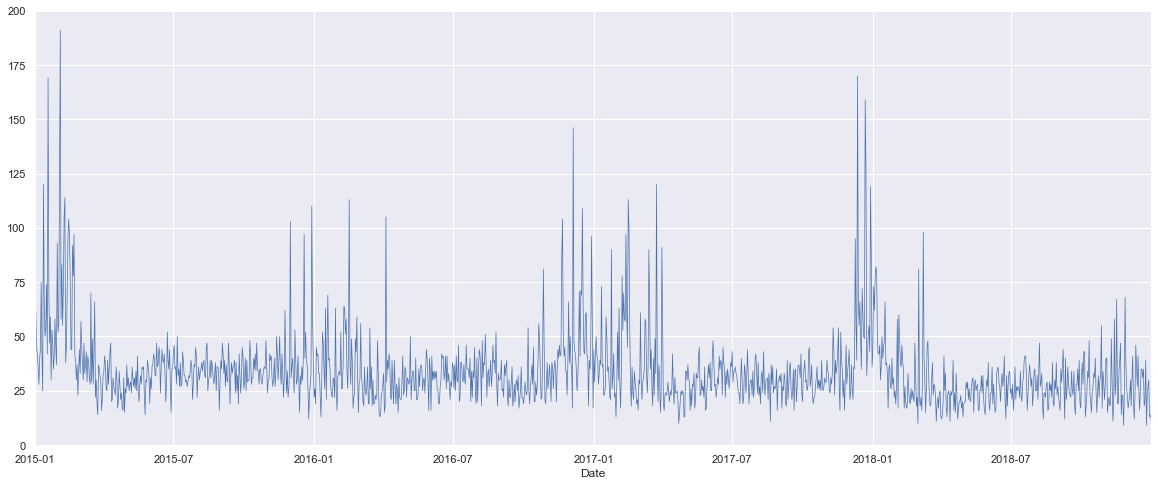

In [4]:
# Time Series of accident from 2015 to 2018
Time=pd.DataFrame(df['ACCIDENTDATE'])
Time['Date'] = Time['ACCIDENTDATE'].dt.date
Date=pd.crosstab(index=Time['Date'],columns="Count")
sns.set(rc={'figure.figsize':(20, 8)})
Date['Count'].plot(linewidth=0.7);

From the time series plot, we could tell that there were more car crashes happened in winter than that in summer. This is reasonable since weather in winter is usually worse. Besides, as known, Vermont snows a lot during winter.

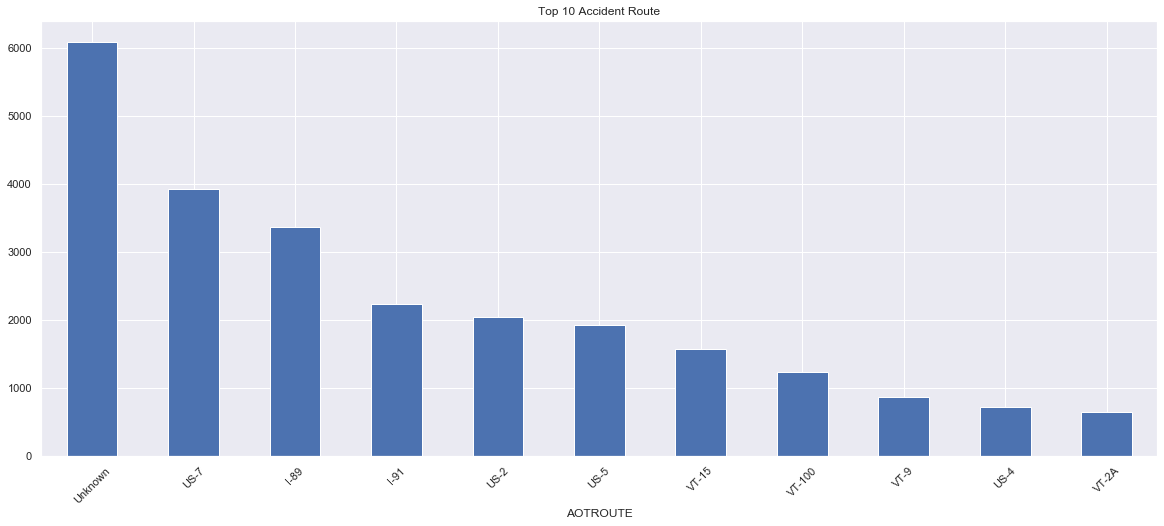

In [5]:
# Summarization statistics
AOTR=pd.crosstab(index=df['AOTROUTE'],columns="Count")
AOTR=AOTR.sort_values(by='Count',ascending=False).head(11)
AOTR.plot(kind='bar', legend = False)
plt.title('Top 10 Accident Route')
plt.xticks(rotation=45)
plt.show()

In [6]:
AOTR

col_0,Count
AOTROUTE,
Unknown,6092
US-7,3928
I-89,3372
I-91,2233
US-2,2038
US-5,1918
VT-15,1568
VT-100,1228
VT-9,861


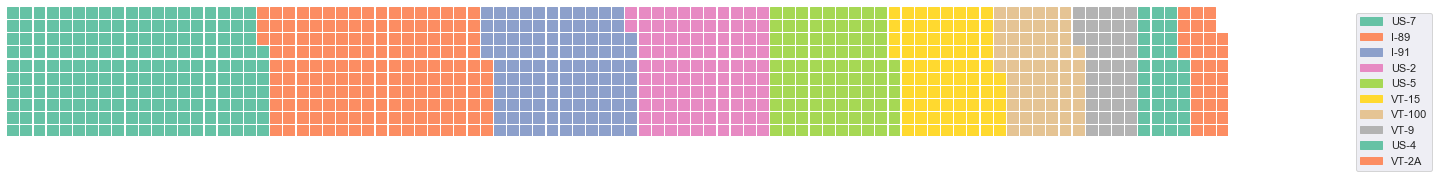

In [7]:
dic = {'US-7':3928,'I-89':3372,'I-91':2233,'US-2':2038,'US-5':1918,'VT-15':1568, 'VT-100':1228, 'VT-9':861, 'US-4':720, 'VT-2A':643}
from pywaffle import Waffle
nRows=10
countsPerBlock=20
fig = plt.figure(
    FigureClass=Waffle, 
    rows=nRows,
    columns=int(np.ceil(sum(dic.values())/nRows/countsPerBlock)),
    values=dic,
    figsize=(20, 10),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)})

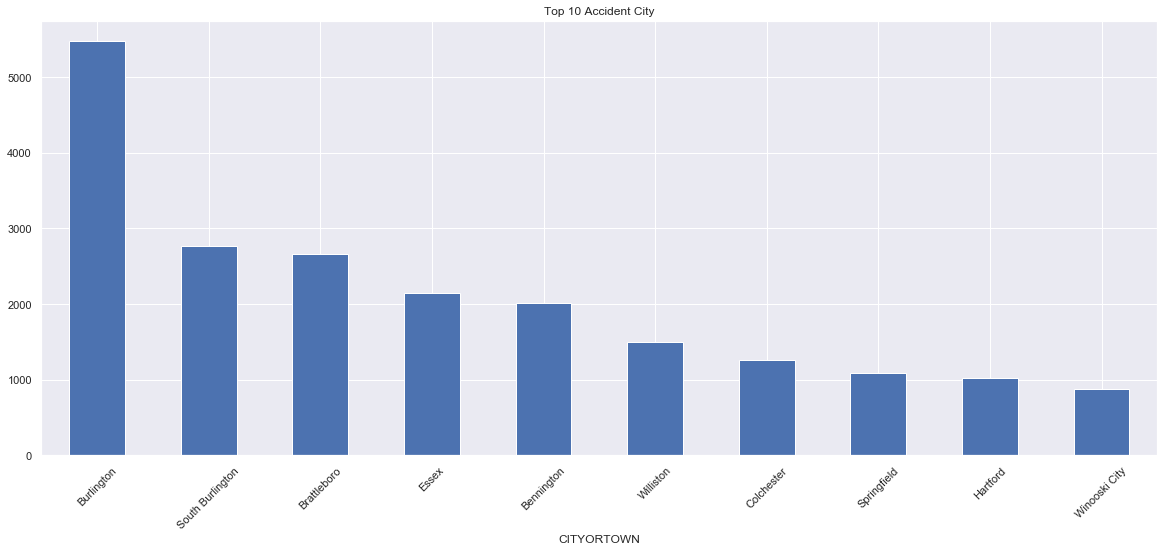

In [8]:
CITY=pd.crosstab(index=df['CITYORTOWN'],columns="Count")
CITY=CITY.sort_values(by='Count',ascending=False).head(10)
CITY.plot(kind='bar', legend = False)
plt.title('Top 10 Accident City')
plt.xticks(rotation=45)
plt.show()

From the above cross-tab graph, we conclude that most car crashes took place in the city called Burlington and the US-7 route. Based on our research, this makes sense because Burlington is the biggest city in Vermont State and US-7 route crosses the city of Burlington.

Text(0.5, 1.0, 'Injury Type and Weather')

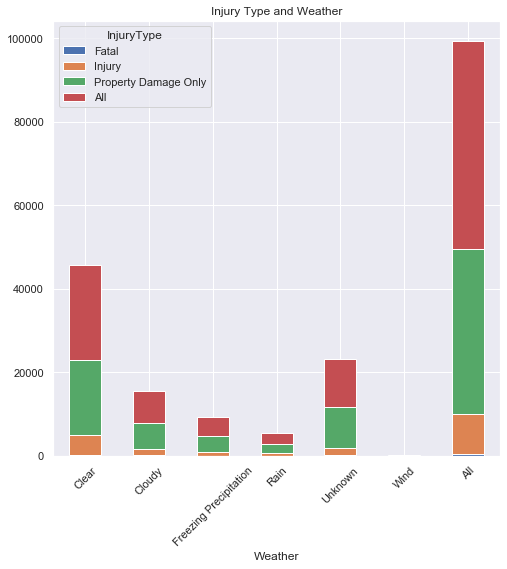

In [9]:
# Contigency tables
weather_injury=pd.crosstab(df['Weather'],df['InjuryType'], margins=True)
weather_injury.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)
plt.xticks(rotation=45)
plt.title('Injury Type and Weather')

Text(0.5, 1.0, 'Injury Type and Day/Night')

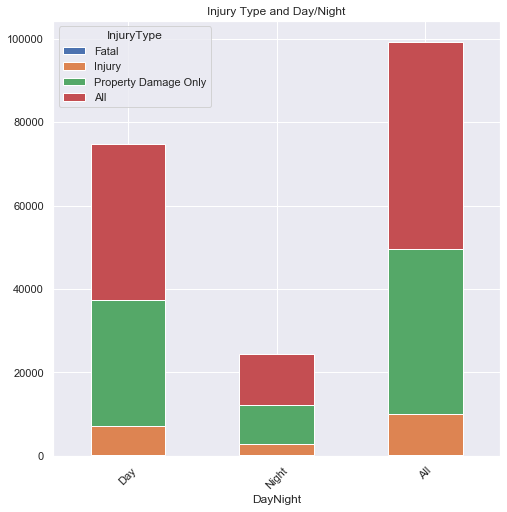

In [10]:
day_night_injury=pd.crosstab(df['DayNight'],df['InjuryType'], margins=True)
day_night_injury.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)
plt.xticks(rotation=45)
plt.title('Injury Type and Day/Night')

We created the contigency table to see how factors related generally. This time, we used three different plots to visualize our data. 

We finally concluded that most acciednts were happened during daytime when the weather is fine, and the major damage type is property damage.

## K-modes clustering

In [11]:
from kmodes.kmodes import KModes
# kmodes reference: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.474.8181&rep=rep1&type=pdf

columns = ["Animal", "DayNight", "Impairment", "InjuryType", "RoadCharacteristics", "SurfaceCondition", "Weather"]
df = pd.read_csv("./combined.csv")[columns]#.sample(100)

print(df.shape)
for repl in ['nan', 'Unknown', 'Other - Explain in Narrative', 'Not Reported']:
  df = df.replace(repl, np.nan, regex=True)

df = df.dropna()

km = KModes(n_clusters=4, init='Cao', verbose=1)
clusters = km.fit_predict(df)

# Print the cluster centroids
f = open("clusters.txt", 'w')
for col in df.columns:
  f.write('{0: <25}'.format(col))
f.write("\n")
for ii in km.cluster_centroids_:
  # these combinations of characteristics tend to be fairly common when accidents occur
  strin = ''
  for jj in ii:
    strin += '{0: <25}'.format(jj)
  print(strin)
  f.write(strin + "\n")
  
f.close()

(49636, 7)
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4435, cost: 47198.0
Run 1, iteration: 2/100, moves: 1841, cost: 45991.0
Run 1, iteration: 3/100, moves: 1175, cost: 45991.0
None/Other               Day                      None                     Property Damage Only     Not at a Junction        Dry                      Clear                    
None/Other               Night                    None                     Injury                   Not at a Junction        Wet                      Cloudy                   
None/Other               Day                      None                     Property Damage Only     Not at a Junction        Snow                     Freezing Precipitation   
None/Other               Day                      None                     Property Damage Only     Four-way Intersection    Wet                      Cloudy                   


## Association Rules

In [12]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

columns = ["Animal", "DayNight", "Impairment", "InjuryType", "RoadCharacteristics", "SurfaceCondition", "Weather"]
df = pd.read_csv("./combined.csv")[columns]

for repl in ['nan', 'Unknown', 'Other - Explain in Narrative', 'Not Reported']:
  df = df.replace(repl, np.nan, regex=True)

df = df.dropna()

df2 = pd.get_dummies(data=df, columns=columns)
print(df2)

frequent_itemsets = apriori(df2, min_support=0.001, use_colnames=True)
print(frequent_itemsets.head())
print(frequent_itemsets.info())

frequent_itemsets.describe()

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("Writing to csv now...")
rules.to_csv("all_rules.csv")

bestrules = rules[(rules['lift'] >= 9) & (rules['confidence'] >= 0.7)].sort_values(by='lift', ascending=False)
bestrules.to_csv("best_rules.csv")

       Animal_Deer  Animal_Domestic  Animal_Moose  Animal_None/Other  \
0                0                0             0                  1   
1                0                0             0                  1   
2                0                0             0                  1   
4                0                0             0                  1   
5                0                0             0                  1   
...            ...              ...           ...                ...   
49629            0                0             0                  1   
49630            0                0             0                  1   
49631            0                0             0                  1   
49632            0                0             0                  1   
49635            0                0             0                  1   

       Animal_Wild  DayNight_Day  DayNight_Night  Impairment_Alcohol  \
0                0             1               0               

## Correlation Analysis

In this section, we take a look at two methods to calculate correlations. Below are the packages used for these excercises.

In [13]:
import scipy.stats as ss
import itertools
from matplotlib import pyplot as plt

### Simple Correlation
First, we need to reload our dataset for calculating the correlation between variables.

In [14]:
corr_df = pd.read_csv('combined.csv')
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 30 columns):
Unnamed: 0              49636 non-null int64
ACCIDENTDATE            49636 non-null object
AOTACTUALMILEPOINT      49636 non-null object
AOTROUTE                49299 non-null object
Animal                  49636 non-null object
CITYORTOWN              49505 non-null object
DIROFCOLLI              37121 non-null object
DayNight                49636 non-null object
HOWMAPPED               49110 non-null object
INTERSECTIONWITH        40181 non-null object
Impairment              49636 non-null object
InjuryType              49636 non-null object
Involving               49636 non-null object
LAT_DD                  49110 non-null float64
LOCALID                 39326 non-null float64
LOC_ERROR               49636 non-null object
LONG_DD                 49110 non-null float64
LRSNUMBER               49636 non-null object
NonReportableAddress    49636 non-null object
REPORTINGAGENCY

Next, we will calculate the correlation using the .corr() method

Text(0.5, 1, 'Basic Correlation')

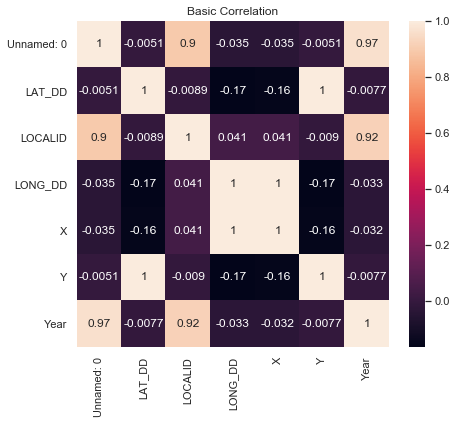

In [15]:
correlation = corr_df.corr()

fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(correlation, annot=True, ax=ax) 
ax.set_title("Basic Correlation")

As you can see, the function worked, however only on the numeric data we have in our dataset. This data used in the correlation analysis used variables such as year, latitude, and longitude. 
As they're only useful to us as identifiers, this analysis isn't useful. Although, it does help us confirm that X is the same as Latitude, and Y is the same as Longitude

### Cramer's V Correlation
In researching potential correlation calculations for our dataset, which mainly is composed of categorical data, we discovered an algorithm that computes correlation on categorical variables.
Note that the following code is taken from a research paper and cited within the following function.

The first step is to chose which columns from the dataset we would like to calculate. We chose every column that was of type "object", and then further reduced the columns to eliminate redundancy.

In [16]:
# We need to choose columns to correlate
chosen_cols = ['Animal','CITYORTOWN','DIROFCOLLI','DayNight',
                 'Impairment', 'InjuryType','Involving','LOCALID','RoadCharacteristics','SurfaceCondition',
                 'Weather','INTERSECTIONWITH']

Next, we define the function used for the calculation of the correlations.

In [17]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

The third step is to run the calculations and save them into a correlation matrix. The try/except statements are there to handle a specific error that occurs within our data. The crosstabulation for a few combinations of variables is much too large to compute, so we utilize an except statement to replace those values with 0. There might be a small correlation, but without further reduction of one of the variables we cannot tell. We chose not to reduce the troubling variable, INTERSECTIONWITH, to ensure that the quality of data remains as high as possible.

In [18]:
# Code taken from https://www.kaggle.com/phaethonprime/eda-and-logistic-regression
# Adjusted to fit our dataset
corr_matrix = np.zeros((len(chosen_cols),len(chosen_cols)))

for col1, col2 in itertools.combinations(chosen_cols, 2):
    try:
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = cramers_corrected_stat(pd.crosstab(corr_df[col1], corr_df[col2]))
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]
    except:
        # If an error is thrown, replace the correlation value with 0.00
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = 0.00
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]

The final step is to plot the correlation using a heatmap.

Text(0.5, 1, 'Cramer V Correlation')

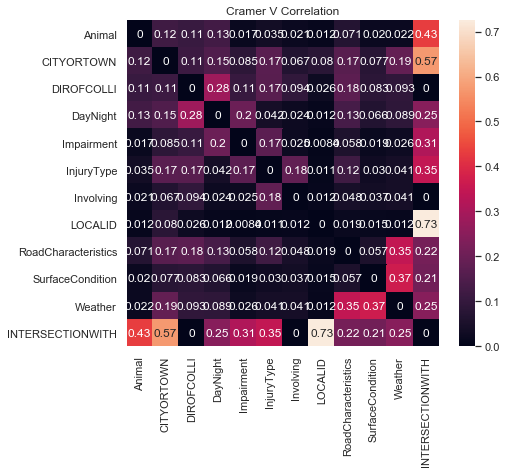

In [19]:
corr = pd.DataFrame(corr_matrix, index=chosen_cols, columns=chosen_cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax)
ax.set_title("Cramer V Correlation")

As the above plot shows us, there are not many strong correlations. Some of the stronger correlations makes sense - INTERSECTIONWITH names roads that exist within CITYORTOWN - but some of them are still interesting.

At a high level, INTERSECTIONWITH and Animal only have a correlation of .43, but this suggests that there are particular intersections that have more animal related car crashes.
Similarily, INTERSECTIONWITH and Impairment also have a slightly stronger correlation, which suggests that there are hotspots of alchol use.
The story gets more interesting when we look at DIROFCOLLI and Weather. Why would weather determine the direction of collision? Let's explore this relationship.

In [20]:
# Crosstab of DIROFCOLLI and Weather
pd.crosstab(corr_df['DIROFCOLLI'],corr_df['Weather'])

Weather,Clear,Cloudy,Freezing Precipitation,Rain,Unknown,Wind
DIROFCOLLI,,,,,,
Head On,900,304,331,110,41,6
"Left Turn and Thru, Angle Broadside -->v--",935,275,70,99,33,2
"Left Turn and Thru, Broadside v<--",447,130,41,53,9,2
"Left Turn and Thru, Head On ^v--",138,44,11,14,4,0
"Left Turn and Thru, Same Direction Sideswipe/Angle Crash vv--",194,66,14,19,6,0
"Left Turns, Opposite Directions, Head On/Angle Crash --^v--",41,10,1,7,0,0
"Left Turns, Same Direciton, Rear End v--v--",9,2,1,2,0,0
"Left Turns, Same Direction, Rear End v--v--",30,10,2,2,1,0
"Left and Right Turns, Simultaneous Turn Crash --vv--",52,13,5,6,5,0


We need to clean the DIROFCOLLI column a little more. We will remove unknowns and group the values together, generate a new confusion matrix, then recalculate Cramer's V.

In [21]:
# Removing Unknowns from data
df2 = corr_df
df2 = df2[df2.DIROFCOLLI != 'Unknown']
df2 = df2[df2.Weather != 'Unknown']

# Grouping values in DIROFCOLLI
# Create groups of values
b_list = ['Left Turn and Thru, Angle Broadside -->v--','Left Turn and Thru, Broadside v<--', 
          'No Turns, Thru moves only, Broadside ^<', 'Right Turn and Thru, Angle Broadside -->^--', 
          'Right Turn and Thru, Broadside ^<--']
h_list = ['Left Turn and Thru, Head On ^v--', 'Left Turns, Opposite Directions, Head On/Angle Crash --^v--', 'Right Turn and Thru, Head On v^--']
s_list = ['Left Turn and Thru, Same Direction Sideswipe/Angle Crash vv--','Left and Right Turns, Simultaneous Turn Crash --vv--', 
          'Opp Direction Sideswipe','Right Turn and Thru, Same Direction Sideswipe/Angle Crash ^^--','Same Direction Sideswipe']
r_list = ['Left Turns, Same Direction, Rear End v--v--','Left Turns, Same Direciton, Rear End v--v--','Rear-to-rear','Right Turn, Same Direciton, Rear End ^--^--',
          'Right Turn, Same Direction, Rear End ^--^--']
            
# Loop through column and replace values
for i in b_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Broadside')
for i in h_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Head On')
for i in s_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Sideswipe')
for i in r_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Rear End')

In [22]:
#  New Crosstab of DIROFCOLLI and Weather
new_crosstab = pd.crosstab(df2['DIROFCOLLI'],df2['Weather'])
new_crosstab

Weather,Clear,Cloudy,Freezing Precipitation,Rain,Wind
DIROFCOLLI,,,,,
Broadside,3267,1040,408,358,9
Head On,1100,363,354,135,6
Other - Explain in Narrative,2360,767,375,231,6
Rear End,5973,1870,675,555,18
Sideswipe,3300,1077,493,323,12
Single Vehicle Crash,5546,2186,2082,976,48


In [23]:
cramers_corrected_stat(new_crosstab)

0.08689155125114546

As you can see, the correlation of 41% was misleading. The actual value is closer to **8%**. The unknowns available in the original data were skewing the calculation, so there really isn't a correlation there. Since we can see how misleading this correlation is, lets look at the relationship between INTERSECTIONWITH and the other variables with greater than 40% correlation.

In [24]:
pd.crosstab(corr_df['INTERSECTIONWITH'],corr_df['Animal'])

Animal,Deer,Domestic,Moose,None/Other,Wild
INTERSECTIONWITH,,,,,
Leicester Whiting Rd,0,0,0,1,0
Taranovich Field,0,0,0,1,0
"""L"" Street",0,0,0,2,0
"""Sharp Corner""",0,0,0,1,0
"""Truly Unique""",0,0,0,1,0
...,...,...,...,...,...
pine St,0,0,0,1,0
s Prospect St,0,0,0,1,0
s Winooski Ave,0,0,0,1,0


The crosstab shows a lot of values for INTERSECTIONWTIH, but we want to keep as many values as possible so we are going to reduce the animal column and then recalculate 

In [25]:
# Grouping values in DIROFCOLLI
# Create groups of values
a_list = ['Animal','Deer','Domestic','Moose','Unknown','Wild']
            
# Loop through column and replace values
for i in a_list:
    df2['Animal'] = df2['Animal'].replace(i, 'Animal Hit')

df2['Animal'] = df2['Animal'].replace('None/Other','No Animal Hit')


intersection_animal = pd.crosstab(df2['INTERSECTIONWITH'],df2['Animal'])


cramers_corrected_stat(intersection_animal)

0.41652405427204287

The correlation lowered a bit but still suggests that there is a small correlation between these variables. We will repeat the process one more time to check INTERSECTIONWITH and Impairment

In [26]:
# Grouping values in DIROFCOLLI
# Create groups of values
i_list = ['Alcohol','Alcohol and Drugs','Drugs']
            
# Loop through column and replace values
for i in i_list:
    df2['Impairment'] = df2['Impairment'].replace(i, 'Impaired')

df2['Impairment'] = df2['Impairment'].replace('None','Not Impaired')

intersection_impairment= pd.crosstab(df2['INTERSECTIONWITH'],df2['Impairment'])


cramers_corrected_stat(intersection_impairment)

0.31079129297570185

This had the same effect as the previous correlation. Let's revisualize the correlation chart again.

Text(0.5, 1, 'Final Cramer V Correlation')

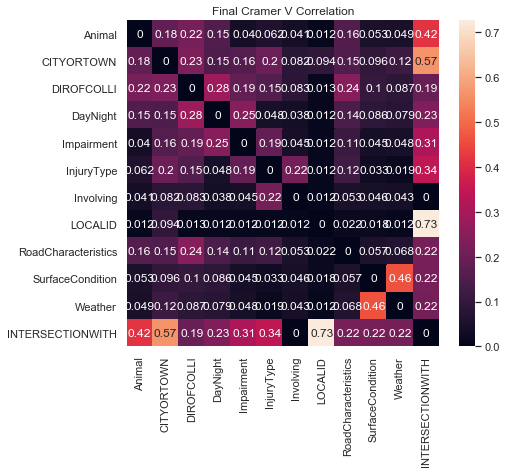

In [27]:
corr_matrix = np.zeros((len(chosen_cols),len(chosen_cols)))

for col1, col2 in itertools.combinations(chosen_cols, 2):
    try:
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df2[col1], df2[col2]))
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]
    except:
        # If an error is thrown, replace the correlation value with 0.00
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = 0.00
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]

        
corr = pd.DataFrame(corr_matrix, index=chosen_cols, columns=chosen_cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax)
ax.set_title("Final Cramer V Correlation")

Interestingly, after cleaning the data some more, we see a stronger correlation between weather and surface condition. This is a relationship we assumed would be visible, as the weather determines if a road is icy or wet for the most part.

In [28]:
# import packages
import re
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline

In [29]:
# read in data
df = pd.read_csv('./combined.csv')

In [30]:
#get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 30 columns):
Unnamed: 0              49636 non-null int64
ACCIDENTDATE            49636 non-null object
AOTACTUALMILEPOINT      49636 non-null object
AOTROUTE                49299 non-null object
Animal                  49636 non-null object
CITYORTOWN              49505 non-null object
DIROFCOLLI              37121 non-null object
DayNight                49636 non-null object
HOWMAPPED               49110 non-null object
INTERSECTIONWITH        40181 non-null object
Impairment              49636 non-null object
InjuryType              49636 non-null object
Involving               49636 non-null object
LAT_DD                  49110 non-null float64
LOCALID                 39326 non-null float64
LOC_ERROR               49636 non-null object
LONG_DD                 49110 non-null float64
LRSNUMBER               49636 non-null object
NonReportableAddress    49636 non-null object
REPORTINGAGENCY

## Dimension Reduction

### Pre-processing

Due to the immense size of the dataset, we must first reduce dimensions manaully based upon intuition derived from background knoweledge of transportation systems.

The AOTRoute column indicates the route number or road name on which the accident occurred. We will do a frequency analysis to determine the routes with highest crash volumes, to see if there are any surprises.

In [31]:
# frequency analyis for AOTRoute
df['AOTROUTE'].value_counts().head(20)

Unknown         6092
US-7            3928
I-89            3372
I-91            2233
US-2            2038
US-5            1918
VT-15           1568
VT-100          1228
VT-9             861
US-4             720
VT-2A            643
VT-30            554
VT-11            502
MinCollector     490
VT-14            486
US-302           430
VT-105           397
VT-116           393
VT-7A            352
VT-103           341
Name: AOTROUTE, dtype: int64

We will keep the ten routes with highest crash volume, and create dummy variables for each. 

In [32]:
# scale down
AOTRoute = pd.Series(np.where(((df['AOTROUTE'] != 'US-7')&(df['AOTROUTE'] != 'I-89')&
                            (df['AOTROUTE'] != 'I-91')&(df['AOTROUTE'] != 'US-2')&
                            (df['AOTROUTE'] != 'US-5')&(df['AOTROUTE'] != 'VT-15')&
                            (df['AOTROUTE'] != 'VT-100')&(df['AOTROUTE'] != 'VT-9')&
                            (df['AOTROUTE'] != 'VT-2A')&(df['AOTROUTE'] != 'US-4')),'Other',df.AOTROUTE))
AOTRoute = pd.get_dummies(AOTRoute)

The Animal column indicates whether an animal is involved, and if so, what kind (for example, deer, domestic, moose, etc). For purposes of dimension reduction, we will reduce this down to only indicate if an animal is involved or not.

In [33]:
# get dummies for animal --> get "none" column for yes/no
animal = pd.get_dummies(df['Animal'])['None/Other']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
animal = pd.Series(np.where(np.array(animal)==0,1,0))

The CityOrTown Column indicates the jurisdiction in which the accident took place. Like the AOTRoute column, we will do a frequency analysis to see the cities with the highest crash volume.

In [34]:
# frequency analyis for CITYORTOWN
df['CITYORTOWN'].value_counts().head(20)

Burlington          5473
South Burlington    2763
Brattleboro         2667
Essex               2149
Bennington          2014
Williston           1501
Colchester          1259
Springfield         1091
Hartford            1019
Winooski City        882
Middlebury           838
Milton               822
Stowe                689
Rutland City         657
Montpelier           552
Barre City           497
Richmond             452
Morristown           444
Shelburne            443
St. Johnsbury        440
Name: CITYORTOWN, dtype: int64

We will keep the ten jurisdictions with highest crash volume, and create dummy variables for each.

In [35]:
# scale down
city_town = pd.Series(np.where(((df['CITYORTOWN'] != 'Burlington')&(df['CITYORTOWN'] != 'Brattleboro')&
                            (df['CITYORTOWN'] != 'South Burlington')&(df['CITYORTOWN'] != 'Essex')&
                            (df['CITYORTOWN'] != 'Bennington')&(df['CITYORTOWN'] != 'Williston')&
                            (df['CITYORTOWN'] != 'Colchester')&(df['CITYORTOWN'] != 'Springfield')&
                            (df['CITYORTOWN'] != 'Hartford')&(df['CITYORTOWN'] != 'Milton')),'Other',df.CITYORTOWN))
city_town = pd.get_dummies(city_town)

For the Day/Night and Impairment columns, we will select a "non-null" case to create a "yes/no" situation. Once we create the dummies, a 1 will be the "yes" case and a 0 will be the "no" case.

In [36]:
# DayNight --> save "night" case only as yes/no
night=pd.get_dummies(df['DayNight'])['Night']

In [37]:
# Impairment --> get "none" column for yes/no
impairment=pd.get_dummies(df['Impairment'])['None']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
impairment = pd.Series(np.where(np.array(impairment)==0,1,0))

For the Injury, Involving, Road Condition, Surface Condition, and Weather columns, we will create dummy variables for each situation, then drop the "null" case.

In [38]:
# get dummies for Injury
injury = pd.get_dummies(df['InjuryType'])
# remove "property damage only" which is the null case
injury = injury.drop(columns=['Property Damage Only'])

In [39]:
# get dummies for Involving
involving = pd.get_dummies(df['Involving'])
# remove "none" column which is the null case
involving = involving.drop(columns = ['None'])

In [40]:
# Get dummies for road condition
roadcondition = pd.get_dummies(df['RoadCondition'])
# drop "none" column which is the null case, unreported situations, and the surface condition; will add in later
roadcondition = roadcondition.drop(columns=['None', 'Other - Explain in Narrative', 'Not reported', 'Unknown',
                                            'Road Surface Condition(wet, icy, snow, slush, etc)'])

In [41]:
# get dummies for surface condition
surfacecondition = pd.get_dummies(df['SurfaceCondition'])
# drop "dry" column which is the null case along with unreported situations
surfacecondition = surfacecondition.drop(columns=['Dry', 'Not Reported', 'Other - Explain in Narrative', 'Unknown'])

In [42]:
# get dummies for weather
weather = pd.get_dummies(df['Weather'])
# drop "clear" column which is the null case along with unreported situations
weather = weather.drop(columns=['Clear', 'Unknown'])

We also would like to look at the seasons. To do this we need to extract the month from the dates. After extracting the month, we use conditional logic to generalize the month to a season.

In [43]:
# get accident dates
datetime = df['ACCIDENTDATE']
months = '' # new string
# use loop to extract month from date string
for i in range(len(datetime)):
    match = re.search(r'\d{4}-\d{2}-\d{2}', datetime[i]).group()
    months += match[5:7] + ','
# remove last extraneous comma from loop
months = months[:-1]
# split comma separated string
months = months.split(",")
# convert to DataFrame
months = pd.Series(months)

In [44]:
# determine season
seasons = ""
for i in range(len(months)):
    if months[i]=='12':
        seasons += 'Winter' + ','
    if months[i]=='01':
        seasons += 'Winter' + ','
    if months[i]=='02':
        seasons += 'Winter' + ','
    if months[i]=='03':
        seasons += 'Spring' + ','
    if months[i]=='04':
        seasons += 'Spring' + ','
    if months[i]=='05':
        seasons += 'Spring' + ','
    if months[i]=='06':
        seasons += 'Summer' + ','
    if months[i]=='07':
        seasons += 'Summer' + ','
    if months[i]=='08':
        seasons += 'Summer' + ','
    if months[i]=='09':
        seasons += 'Fall' + ','
    if months[i]=='10':
        seasons += 'Fall' + ','
    if months[i]=='11':
        seasons += 'Fall' + ','
# remove last extraneous comma from loop
seasons = seasons[:-1]
# split comma separated string
seasons = seasons.split(",")
# convert to DataFrame
seasons = pd.Series(seasons)
seasons = pd.get_dummies(seasons)

During our data manipulation phase, we assembled our dummy variables into series or dataframes. Here we will combine these together to pass to the PCA method.

In [45]:
# Build data frame for PCA
pca_df = pd.concat([animal, night, impairment], axis=1)
pca_df.columns=['Animal', 'Night', 'Impairment']
pca_df = pd.concat([pca_df, AOTRoute, city_town, injury, involving, roadcondition, surfacecondition, weather, seasons],
                   axis=1, sort=False)
pca_df

,Animal,Night,Impairment,I-89,I-91,Other,US-2,US-4,US-5,US-7,...,Water (standing / moving),Wet,Cloudy,Freezing Precipitation,Rain,Wind,Fall,Spring,Summer,Winter
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
2,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49631,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
49632,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49633,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49634,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [46]:
# look at dataframe
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 53 columns):
Animal                                                      49636 non-null int64
Night                                                       49636 non-null uint8
Impairment                                                  49636 non-null int64
I-89                                                        49636 non-null uint8
I-91                                                        49636 non-null uint8
Other                                                       49636 non-null uint8
US-2                                                        49636 non-null uint8
US-4                                                        49636 non-null uint8
US-5                                                        49636 non-null uint8
US-7                                                        49636 non-null uint8
VT-100                                                      49636 non-null uint8


### Principal Component Analysis

Here we will do the Principal Component Analysis. To start we will run the PCA with all 53 dummy variable predictors.

In [47]:
# do PCA with full 53 components
pca_full = PCA(n_components=53)
# fit model
pca_full.fit(pca_df)

PCA(copy=True, iterated_power='auto', n_components=53, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [48]:
# check to see how much variance each explains
var_full = pca_full.explained_variance_ratio_
print(var_full)

[1.08520608e-01 9.27149305e-02 8.83621489e-02 7.76187884e-02
 7.32178891e-02 6.06025505e-02 5.13720104e-02 5.00849372e-02
 4.53743717e-02 3.31392437e-02 3.06239650e-02 2.36469364e-02
 2.18713378e-02 1.88299001e-02 1.79841774e-02 1.61751342e-02
 1.55684458e-02 1.49069656e-02 1.32713414e-02 1.22519241e-02
 1.16295905e-02 1.12142001e-02 1.01413956e-02 9.58618700e-03
 8.95341680e-03 8.84952338e-03 8.23250615e-03 7.38743432e-03
 7.26366990e-03 7.21090187e-03 5.88512265e-03 5.40586280e-03
 5.19223212e-03 4.42976934e-03 3.93397206e-03 3.36075924e-03
 3.34124269e-03 2.51350991e-03 1.73157682e-03 1.69455435e-03
 1.33595356e-03 1.01481392e-03 8.32376359e-04 7.01889737e-04
 6.84822386e-04 5.57851844e-04 4.70995504e-04 1.79771117e-04
 6.66137273e-05 5.98777306e-05 6.26856625e-32 3.74665758e-32
 1.86057507e-32]


In [49]:
# see cumulative variance
var_full_cumul = np.cumsum(np.round(pca_full.explained_variance_ratio_, decimals=4)*100)

print(var_full_cumul)

[ 10.85  20.12  28.96  36.72  44.04  50.1   55.24  60.25  64.79  68.1
  71.16  73.52  75.71  77.59  79.39  81.01  82.57  84.06  85.39  86.62
  87.78  88.9   89.91  90.87  91.77  92.65  93.47  94.21  94.94  95.66
  96.25  96.79  97.31  97.75  98.14  98.48  98.81  99.06  99.23  99.4
  99.53  99.63  99.71  99.78  99.85  99.91  99.96  99.98  99.99 100.
 100.   100.   100.  ]


Text(0, 0.5, 'Cumulative Variance Explained')

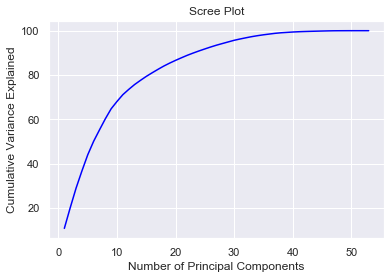

In [50]:
var1 = pd.DataFrame(var_full_cumul, index=np.arange(1,54))
plt.plot(var1,color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')

According to the scree plot, we would still have 90% representativeness if we pare down the number of predictors to 25.

In [51]:
# choose 25 component solution
# Select the number of components
pca25 = PCA(n_components=25)
pca25.fit(pca_df)
data_pca25 = pca25.transform(pca_df)

# Convert the numpy array to pandas DataFrame
data_pca25 = pd.DataFrame(data_pca25)
data_pca25.columns = ["PC"+str(i) for i in range(1,26)]

# Show the head of the DataFrame
data_pca25.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,0.663705,0.359969,-0.413859,-0.180413,-0.099968,-0.364336,-0.218814,-0.130975,-0.007144,-0.380998,...,0.008567,-0.028585,-0.030323,0.029702,-0.034935,0.021796,-0.027165,0.006157,-0.019874,0.033618
1,1.161248,0.123312,-0.524928,0.069450,-0.077283,0.628896,0.910328,0.291481,-0.486942,0.340139,...,-0.452265,0.302866,-0.141522,0.015579,-0.085060,0.013467,-0.221484,0.047338,-0.029364,-0.007142
2,0.860565,0.203190,-0.538333,-0.002544,-0.113390,0.691473,-0.240665,-0.082952,0.174774,-0.404844,...,0.646097,0.507348,0.100721,-0.060009,0.036910,0.004278,-0.029285,-0.011929,0.043365,0.010177
3,0.236774,0.783364,0.799783,0.150071,-0.091589,0.871171,-0.210830,0.076860,0.031712,-0.455569,...,0.017660,-0.073072,-0.141273,0.508941,0.051525,0.090562,-0.082508,-0.295622,0.061231,0.276640
4,0.825372,0.314179,-0.499030,0.023777,-0.096924,0.438948,-0.097491,0.098302,1.006000,-0.023296,...,-0.099582,-0.091149,-0.088672,0.032395,-0.014102,0.023650,0.034442,0.004966,-0.082061,0.036329
5,0.860565,0.203190,-0.538333,-0.002544,-0.113390,0.691473,-0.240665,-0.082952,0.174774,-0.404844,...,0.646097,0.507348,0.100721,-0.060009,0.036910,0.004278,-0.029285,-0.011929,0.043365,0.010177
6,0.850333,0.035329,0.486792,-0.117931,-0.065603,-0.366567,-0.284837,-0.174421,0.015364,-0.363657,...,0.068584,0.021685,-0.029211,0.214563,-0.055529,-0.068916,-0.027710,0.123692,-0.158364,-0.406147
7,0.483369,0.688876,0.913240,0.026094,-0.039458,0.009721,-0.371587,0.114550,-0.263006,0.258799,...,1.129015,0.209161,0.325630,0.018111,0.091864,0.619951,-0.059176,0.051931,0.008369,-0.353398
8,0.095277,1.076148,-0.169185,0.082321,-0.125065,0.861855,-0.154934,0.103766,0.001242,-0.484705,...,-0.040007,-0.096255,-0.075853,0.028420,-0.026456,-0.042788,-0.012127,0.049208,-0.062744,-0.023095
9,0.663705,0.359969,-0.413859,-0.180413,-0.099968,-0.364336,-0.218814,-0.130975,-0.007144,-0.380998,...,0.008567,-0.028585,-0.030323,0.029702,-0.034935,0.021796,-0.027165,0.006157,-0.019874,0.033618


In [52]:
#correlation analysis
pca25_corr = data_pca25.corr()

Text(0.5, 1, 'Basic Correlation')

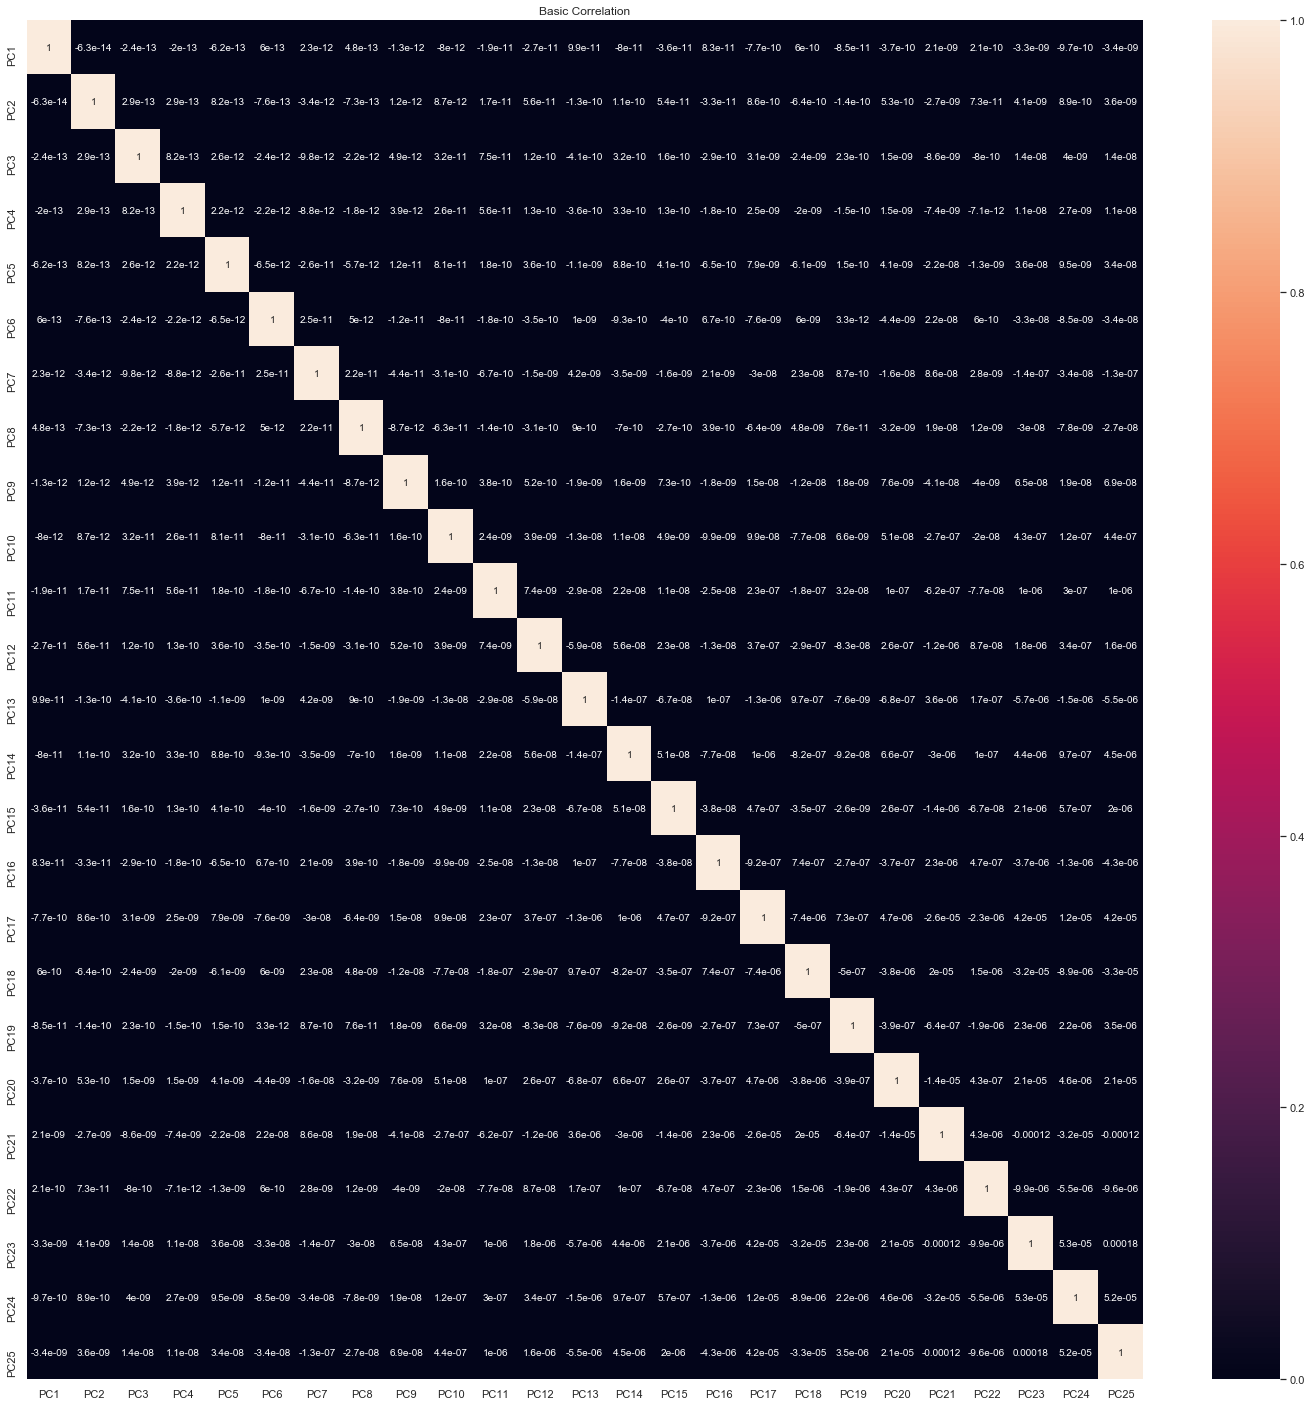

In [53]:
# visualize correlation
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.heatmap(pca25_corr, annot=True, ax=ax) 
ax.set_title("Basic Correlation")

According to the visualization, there is very little multicollinearity issue in the 25-predictor PCA. This means that there is at least some semblance of a pattern to predict what causes accidents (despite having no non-examples in the dataset). 

## Machine Learning

Conduct the regression and predictive analysis to get a better understanding of our dataset and provide proper suggestions regarding our findings.

We chose Logistic Regression for regression analysis because our dataset is all categorical variables. For clustering, we used K-modes to find out what combination of weather, road conditions and other factors would most likely cause car accidents. We chose Support Vector Machine, Decision Tree, Random Forest, and Gradient Boosting Machine for predictive analysis and compared their performance to get a better result.

## Support Vector Machine

This section explores the use of a support vector machine in determining which factors result in injury.

In [54]:
# Import needed packages and data.
from sklearn import metrics
svm_df = pd.read_csv('combined.csv')

We need to organize the data into a useable form for the model. The random forest model as well as the regression analysis have shown us that the biggest determining variables for this business question are Impairment, Involving, and DayNight. We will only worry about these features.

In [55]:
# Grouping values in Impairment
# Create groups of values
i_list = ['Alcohol','Alcohol and Drugs','Drugs']
            
# Loop through column and replace values
for i in i_list:
    svm_df['Impairment'] = svm_df['Impairment'].replace(i, 'Impaired')

svm_df['Impairment'] = svm_df['Impairment'].replace('None','Not Impaired')
svm_df['Impairment'] = svm_df['Impairment'].replace('Not Impaired',0)
svm_df['Impairment'] = svm_df['Impairment'].replace('Impaired',1)
svm_df['DayNight'] = svm_df['DayNight'].replace('Day',1)
svm_df['DayNight'] = svm_df['DayNight'].replace('Night',0)

# Factorizing here. Dummy variables increases complexity to a point in which we cannot compute.
svm_df['fInvolving'], i = pd.factorize(svm_df['Involving'], sort = True)


# Creating a column to indicate if there was an injury or not.
svm_df['isInjury'] = svm_df['InjuryType'].replace('Fatal',1)
svm_df['isInjury'] = svm_df['isInjury'].replace('Injury',1)
svm_df['isInjury'] = svm_df['isInjury'].replace('Property Damage Only',0)
svm_df = svm_df.dropna()

Next, we need to indicate our y and X.

In [56]:
y = svm_df['isInjury']

X = svm_df[['Impairment','DayNight','fInvolving']]
X

,Impairment,DayNight,fInvolving
14171,0,1,3
14172,0,1,3
14173,0,0,3
14175,0,1,3
14176,0,1,3
...,...,...,...
39320,0,1,3
39321,0,1,3
39322,0,1,4
39324,0,0,3


Let's partition the data.

In [57]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

Next we will train the model. Here we train five different support vector machines. Note that the computation time on this can be quite long. The reason we are creating so many models is because we want to utilize as many kernel modes as possible to achieve the best possible model.

In [59]:
from sklearn import svm # "Support vector classifier"
svm1 = svm.LinearSVC(max_iter=1000000, C=1)
svm1.fit(X, y)

svm2 = svm.SVC(gamma="auto")
svm2.fit(X_train,y_train)

svm3 = svm.SVC(kernel = 'linear', C = 1)
svm3.fit(X_train, y_train)

svm4 = svm.SVC(kernel='rbf', gamma=0.7, C=1)
svm4.fit(X_train, y_train)

svm5 = svm.SVC(kernel='poly', degree=3, gamma='auto', C=1)
svm5.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

The penultimate step is to create prediction sets before we can test for accuracy.

In [61]:
y_pred1 = svm1.predict(X_test)
y_pred2 = svm2.predict(X_test)
y_pred3 = svm3.predict(X_test)
y_pred4 = svm4.predict(X_test)
y_pred5 = svm5.predict(X_test)

#Add prediction sets to a list for comparisons later
svms = [y_pred1,y_pred2,y_pred3,y_pred4,y_pred5]

Finally, let's print both the accuracy and AUC score for these models.

In [62]:
n = 1
for i in svms:
    print("Model " + str(n) + ": Accuracy=" + str(metrics.accuracy_score(y_test,i)) + ', AUC=' + str(metrics.roc_auc_score(y_test,i)))
    n += 1

Model 1: Accuracy=0.7989985693848355, AUC=0.5
Model 2: Accuracy=0.8197424892703863, AUC=0.5629211442698892
Model 3: Accuracy=0.7989985693848355, AUC=0.5
Model 4: Accuracy=0.8197424892703863, AUC=0.5629211442698892
Model 5: Accuracy=0.8090128755364807, AUC=0.5295720935270822


As we can see here, models 2 and 4 have the same results.

## Decision Tree

For the decision tree, we will use the DataFrame that resulted from Principal Component Analysis. However, our dataset is very imbalanced. There are much more non-injury crashes than injury crashes. So we need to downsample our dataset to make the number of injury and non-injury crashes equitable. This will help the model accurately predict injury crashes.

In [149]:
pca_df[pca_df.Injury==1]

,Animal,Night,Impairment,I-89,I-91,Other,US-2,US-4,US-5,US-7,...,Water (standing / moving),Wet,Cloudy,Freezing Precipitation,Rain,Wind,Fall,Spring,Summer,Winter
1,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
35,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49603,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
49608,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49617,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
49623,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


From the above, we conclude that there are 9791 injury crashes. Let's now downsample the non-injury dataset.

In [169]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = pca_df[pca_df.Injury==0]
df_minority = pca_df[pca_df.Injury==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=9791,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_downsampled.describe()

,Animal,Night,Impairment,I-89,I-91,Other,US-2,US-4,US-5,US-7,...,Water (standing / moving),Wet,Cloudy,Freezing Precipitation,Rain,Wind,Fall,Spring,Summer,Winter
count,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,...,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000,19608.000000
mean,0.025398,0.257038,0.072368,0.077009,0.047073,0.614596,0.040596,0.014280,0.037995,0.078335,...,0.002703,0.163454,0.162179,0.090371,0.061302,0.001989,0.237709,0.215473,0.240769,0.306049
std,0.157334,0.437012,0.259104,0.266613,0.211800,0.486703,0.197357,0.118645,0.191188,0.268705,...,0.051921,0.369789,0.368624,0.286720,0.239889,0.044555,0.425691,0.411161,0.427561,0.460862
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we can separate out our response variable. We will make Injury our response variable. We will then remove the Fatal column as well as that is a different response dummy. Finally, we will create the train/test split.

In [170]:
y = df_downsampled['Injury']
x = df_downsampled.drop(columns = ['Fatal', 'Injury'])

In [171]:
# 20-80% simple split
# To make the result reproducible, set the random_state
train_y,test_y,train_x,test_x = train_test_split(y, x,
                                                 test_size=0.25,
                                                 random_state=123)

Let's first train a decision tree model using all the predictors.

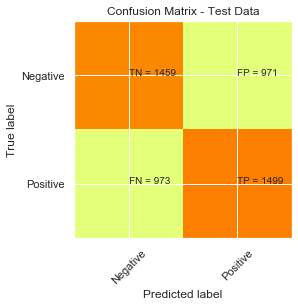

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      2430
           1       0.61      0.61      0.61      2472

    accuracy                           0.60      4902
   macro avg       0.60      0.60      0.60      4902
weighted avg       0.60      0.60      0.60      4902



In [172]:
from sklearn import tree
# Decision trees for classification
dt = tree.DecisionTreeClassifier(max_features='sqrt')
dt = dt.fit(train_x, train_y)
pred_y_dt = dt.predict(test_x)
print_cm(metrics.confusion_matrix(test_y, pred_y_dt))
print(metrics.classification_report(test_y, pred_y_dt))

Accuracy is not good. So we can use feature importance scores to use only the most important features.

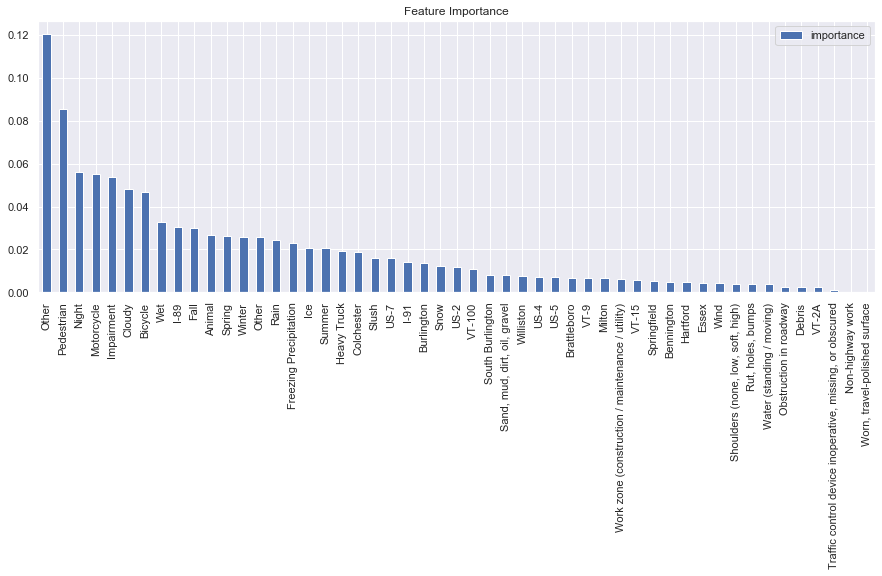

In [173]:
# importance scores
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = train_x.columns,
                                   columns=['importance'])
feature_importances = feature_importances.sort_values('importance',ascending=False)

#bar chart
feature_importances.plot(kind = 'bar',figsize=(15,5),
                         title='Feature Importance')

Let's first try a model with fifteen features.

In [174]:
# Select the 10 most importance features
train_x_imp = train_x[feature_importances.index[range(15)]]
train_x_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14706 entries, 49070 to 29111
Data columns (total 17 columns):
Other         14706 non-null uint8
Other         14706 non-null uint8
Pedestrian    14706 non-null uint8
Night         14706 non-null uint8
Motorcycle    14706 non-null uint8
Impairment    14706 non-null int64
Cloudy        14706 non-null uint8
Bicycle       14706 non-null uint8
Wet           14706 non-null uint8
I-89          14706 non-null uint8
Fall          14706 non-null uint8
Animal        14706 non-null int64
Spring        14706 non-null uint8
Winter        14706 non-null uint8
Other         14706 non-null uint8
Other         14706 non-null uint8
Rain          14706 non-null uint8
dtypes: int64(2), uint8(15)
memory usage: 560.1 KB


In [175]:
test_x_imp = test_x[feature_importances.index[range(15)]]
test_x_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4902 entries, 6391 to 24284
Data columns (total 17 columns):
Other         4902 non-null uint8
Other         4902 non-null uint8
Pedestrian    4902 non-null uint8
Night         4902 non-null uint8
Motorcycle    4902 non-null uint8
Impairment    4902 non-null int64
Cloudy        4902 non-null uint8
Bicycle       4902 non-null uint8
Wet           4902 non-null uint8
I-89          4902 non-null uint8
Fall          4902 non-null uint8
Animal        4902 non-null int64
Spring        4902 non-null uint8
Winter        4902 non-null uint8
Other         4902 non-null uint8
Other         4902 non-null uint8
Rain          4902 non-null uint8
dtypes: int64(2), uint8(15)
memory usage: 186.7 KB


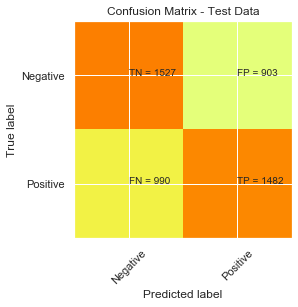

              precision    recall  f1-score   support

           0       0.61      0.63      0.62      2430
           1       0.62      0.60      0.61      2472

    accuracy                           0.61      4902
   macro avg       0.61      0.61      0.61      4902
weighted avg       0.61      0.61      0.61      4902



In [176]:
# Decision trees for classification, use entropy criterion (gini by default)
dt2 = tree.DecisionTreeClassifier(max_features='sqrt')
dt2 = dt2.fit(train_x_imp, train_y)
pred_y_dt2 = dt2.predict(test_x_imp)
print_cm(metrics.confusion_matrix(test_y, pred_y_dt2))
print(metrics.classification_report(test_y, pred_y_dt2))

Performance has improved. Let's try with ten predictors.

In [177]:
# Select the 10 most importance features
train_x_imp10 = train_x[feature_importances.index[range(10)]]
train_x_imp10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14706 entries, 49070 to 29111
Data columns (total 11 columns):
Other         14706 non-null uint8
Other         14706 non-null uint8
Pedestrian    14706 non-null uint8
Night         14706 non-null uint8
Motorcycle    14706 non-null uint8
Impairment    14706 non-null int64
Cloudy        14706 non-null uint8
Bicycle       14706 non-null uint8
Wet           14706 non-null uint8
I-89          14706 non-null uint8
Fall          14706 non-null uint8
dtypes: int64(1), uint8(10)
memory usage: 373.4 KB


In [178]:
test_x_imp10 = test_x[feature_importances.index[range(10)]]
test_x_imp10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4902 entries, 6391 to 24284
Data columns (total 11 columns):
Other         4902 non-null uint8
Other         4902 non-null uint8
Pedestrian    4902 non-null uint8
Night         4902 non-null uint8
Motorcycle    4902 non-null uint8
Impairment    4902 non-null int64
Cloudy        4902 non-null uint8
Bicycle       4902 non-null uint8
Wet           4902 non-null uint8
I-89          4902 non-null uint8
Fall          4902 non-null uint8
dtypes: int64(1), uint8(10)
memory usage: 124.5 KB


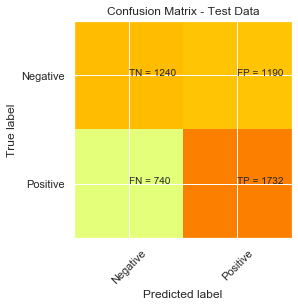

              precision    recall  f1-score   support

           0       0.63      0.51      0.56      2430
           1       0.59      0.70      0.64      2472

    accuracy                           0.61      4902
   macro avg       0.61      0.61      0.60      4902
weighted avg       0.61      0.61      0.60      4902



In [179]:
# Decision trees for classification, use entropy criterion (gini by default)
dt3 = tree.DecisionTreeClassifier(max_features='sqrt', random_state=123)
dt3 = dt3.fit(train_x_imp10, train_y)
pred_y_dt3 = dt3.predict(test_x_imp10)
print_cm(metrics.confusion_matrix(test_y, pred_y_dt3))
print(metrics.classification_report(test_y, pred_y_dt3))

Performance has improved further, especially with recall (which is important for this case). We can try five predictors, but having too few predictors would not be good in determining factors for accidents, since not all accidents are caused by the same thing.

In [180]:
# Select the 5 most importance features
train_x_imp5 = train_x[feature_importances.index[range(5)]]
train_x_imp5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14706 entries, 49070 to 29111
Data columns (total 6 columns):
Other         14706 non-null uint8
Other         14706 non-null uint8
Pedestrian    14706 non-null uint8
Night         14706 non-null uint8
Motorcycle    14706 non-null uint8
Impairment    14706 non-null int64
dtypes: int64(1), uint8(5)
memory usage: 301.6 KB


In [181]:
test_x_imp5 = test_x[feature_importances.index[range(5)]]
test_x_imp5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4902 entries, 6391 to 24284
Data columns (total 6 columns):
Other         4902 non-null uint8
Other         4902 non-null uint8
Pedestrian    4902 non-null uint8
Night         4902 non-null uint8
Motorcycle    4902 non-null uint8
Impairment    4902 non-null int64
dtypes: int64(1), uint8(5)
memory usage: 100.5 KB


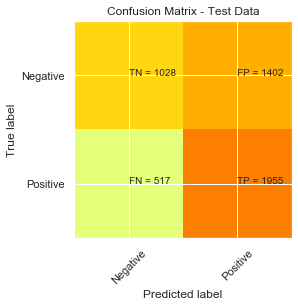

              precision    recall  f1-score   support

           0       0.67      0.42      0.52      2430
           1       0.58      0.79      0.67      2472

    accuracy                           0.61      4902
   macro avg       0.62      0.61      0.59      4902
weighted avg       0.62      0.61      0.59      4902



In [182]:
# Decision trees for classification, use entropy criterion (gini by default)
dt4 = tree.DecisionTreeClassifier(max_features='sqrt')
dt4 = dt4.fit(train_x_imp5, train_y)
pred_y_dt4 = dt4.predict(test_x_imp5)
print_cm(metrics.confusion_matrix(test_y, pred_y_dt4))
print(metrics.classification_report(test_y, pred_y_dt4))

As expected, accuracy has decreased, even though recall has slightly improved. Let's choose the ten-predictor model for the final visualization.

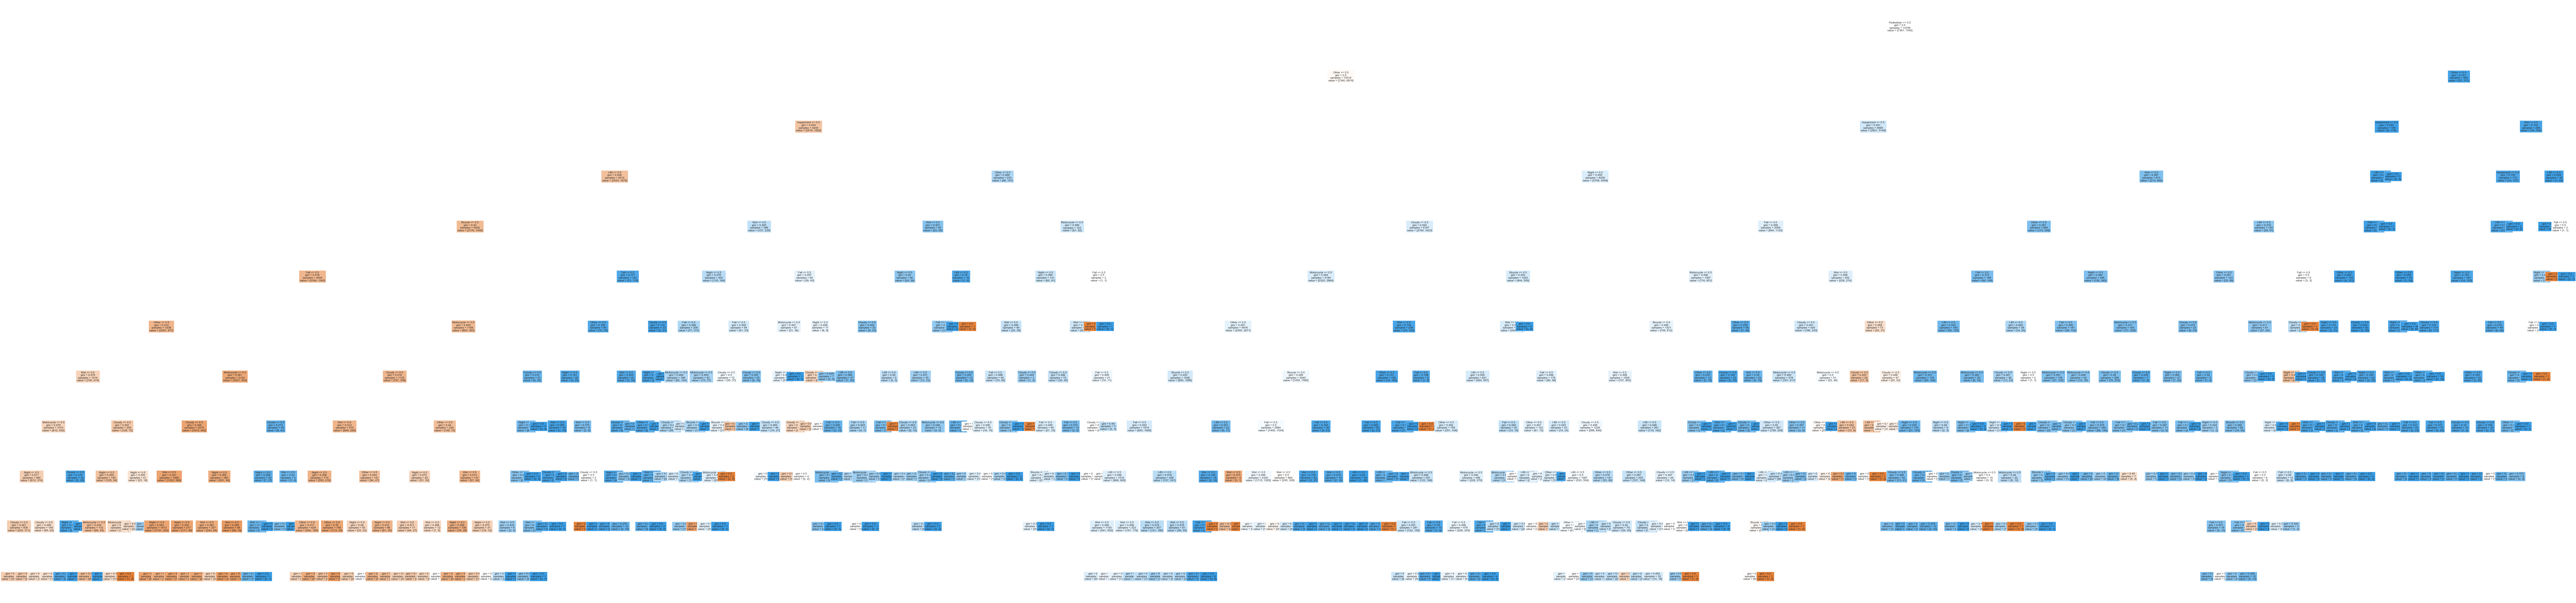

In [183]:
# visualize decision tree
fig, ax = plt.subplots(figsize=(200, 48))
dt_viz = tree.plot_tree(dt3, filled=True, fontsize = 12, feature_names=train_x_imp10.columns)
plt.show()

## Random Forest

In [125]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [126]:
#read data 
rf_df = pd.read_csv('combined.csv')
rf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 30 columns):
Unnamed: 0              49636 non-null int64
ACCIDENTDATE            49636 non-null object
AOTACTUALMILEPOINT      49636 non-null object
AOTROUTE                49299 non-null object
Animal                  49636 non-null object
CITYORTOWN              49505 non-null object
DIROFCOLLI              37121 non-null object
DayNight                49636 non-null object
HOWMAPPED               49110 non-null object
INTERSECTIONWITH        40181 non-null object
Impairment              49636 non-null object
InjuryType              49636 non-null object
Involving               49636 non-null object
LAT_DD                  49110 non-null float64
LOCALID                 39326 non-null float64
LOC_ERROR               49636 non-null object
LONG_DD                 49110 non-null float64
LRSNUMBER               49636 non-null object
NonReportableAddress    49636 non-null object
REPORTINGAGENCY

In [127]:
# Preprocess data
AOTRoute = pd.Series(np.where(((df['AOTROUTE'] != 'US-7')&(df['AOTROUTE'] != 'I-89')&
                            (df['AOTROUTE'] != 'I-91')&(df['AOTROUTE'] != 'US-2')&
                            (df['AOTROUTE'] != 'US-5')&(df['AOTROUTE'] != 'VT-15')&
                            (df['AOTROUTE'] != 'VT-100')&(df['AOTROUTE'] != 'VT-9')&
                            (df['AOTROUTE'] != 'VT-2A')&(df['AOTROUTE'] != 'US-4')),'Other',df.AOTROUTE))
AOTRoute = pd.get_dummies(AOTRoute)

# get dummies for animal --> get "none" column for yes/no
animal = pd.get_dummies(df['Animal'])['None/Other']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
animal = pd.Series(np.where(np.array(animal)==0,1,0))

city_town = pd.Series(np.where(((df['CITYORTOWN'] != 'Burlington')&(df['CITYORTOWN'] != 'Brattleboro')&
                            (df['CITYORTOWN'] != 'South Burlington')&(df['CITYORTOWN'] != 'Essex')&
                            (df['CITYORTOWN'] != 'Bennington')&(df['CITYORTOWN'] != 'Williston')&
                            (df['CITYORTOWN'] != 'Colchester')&(df['CITYORTOWN'] != 'Springfield')&
                            (df['CITYORTOWN'] != 'Hartford')&(df['CITYORTOWN'] != 'Milton')),'Other',df.CITYORTOWN))
city_town = pd.get_dummies(city_town)

# DayNight --> save "night" case only as yes/no
night=pd.get_dummies(df['DayNight'])['Night']

# Impairment --> get "none" column for yes/no
impairment=pd.get_dummies(df['Impairment'])['None']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
impairment = pd.Series(np.where(np.array(impairment)==0,1,0))

# get dummies for Involving
involving = pd.get_dummies(df['Involving'])
# remove "none" column which is the null case
involving = involving.drop(columns = ['None'])

# Get dummies for road condition
roadcondition = pd.get_dummies(df['RoadCondition'])
# drop "none" column which is the null case, unreported situations, and the surface condition; will add in later
roadcondition = roadcondition.drop(columns=['None', 'Other - Explain in Narrative', 'Not reported', 'Unknown',
                                            'Road Surface Condition(wet, icy, snow, slush, etc)'])

# get dummies for surface condition
surfacecondition = pd.get_dummies(df['SurfaceCondition'])
# drop "dry" column which is the null case along with unreported situations
surfacecondition = surfacecondition.drop(columns=['Dry', 'Not Reported', 'Other - Explain in Narrative', 'Unknown'])

# get dummies for weather
weather = pd.get_dummies(df['Weather'])
# drop "clear" column which is the null case along with unreported situations
weather = weather.drop(columns=['Clear', 'Unknown'])

# get accident dates
datetime = df['ACCIDENTDATE']
months = '' # new string
# use loop to extract month from date string
for i in range(len(datetime)):
    match = re.search(r'\d{4}-\d{2}-\d{2}', datetime[i]).group()
    months += match[5:7] + ','
# remove last extraneous comma from loop
months = months[:-1]
# split comma separated string
months = months.split(",")
# convert to DataFrame
months = pd.Series(months)

# determine season
seasons = ""
for i in range(len(months)):
    if months[i]=='12':
        seasons += 'Winter' + ','
    if months[i]=='01':
        seasons += 'Winter' + ','
    if months[i]=='02':
        seasons += 'Winter' + ','
    if months[i]=='03':
        seasons += 'Spring' + ','
    if months[i]=='04':
        seasons += 'Spring' + ','
    if months[i]=='05':
        seasons += 'Spring' + ','
    if months[i]=='06':
        seasons += 'Summer' + ','
    if months[i]=='07':
        seasons += 'Summer' + ','
    if months[i]=='08':
        seasons += 'Summer' + ','
    if months[i]=='09':
        seasons += 'Fall' + ','
    if months[i]=='10':
        seasons += 'Fall' + ','
    if months[i]=='11':
        seasons += 'Fall' + ','
# remove last extraneous comma from loop
seasons = seasons[:-1]
# split comma separated string
seasons = seasons.split(",")
# convert to DataFrame
seasons = pd.Series(seasons)
seasons = pd.get_dummies(seasons)

injury = df['InjuryType'].copy()

for i in range(len(injury)):
    if injury.loc[i] == 'Property Damage Only':
        injury.loc[i] = 0
    else:
        injury.loc[i] = 1

# Build data frame for RF
rf_df = pd.concat([animal, night, impairment], axis=1)
rf_df.columns=['Animal', 'Night', 'Impairment']
rf_df = pd.concat([rf_df, AOTRoute, city_town, involving, roadcondition, surfacecondition, weather, seasons,injury],
                   axis=1, sort=False)

rf_df.rename(columns={'InjuryType':'injury'},  inplace=True)
rf_df.head()

,Animal,Night,Impairment,I-89,I-91,Other,US-2,US-4,US-5,US-7,...,Wet,Cloudy,Freezing Precipitation,Rain,Wind,Fall,Spring,Summer,Winter,injury
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,1
2,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [128]:
rf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 52 columns):
Animal                                                      49636 non-null int64
Night                                                       49636 non-null uint8
Impairment                                                  49636 non-null int64
I-89                                                        49636 non-null uint8
I-91                                                        49636 non-null uint8
Other                                                       49636 non-null uint8
US-2                                                        49636 non-null uint8
US-4                                                        49636 non-null uint8
US-5                                                        49636 non-null uint8
US-7                                                        49636 non-null uint8
VT-100                                                      49636 non-null uint8


In [129]:
# Create X and y for the model
y=rf_df['injury']
X = rf_df.copy()
X = X.drop(['injury'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 51 columns):
Animal                                                      49636 non-null int64
Night                                                       49636 non-null uint8
Impairment                                                  49636 non-null int64
I-89                                                        49636 non-null uint8
I-91                                                        49636 non-null uint8
Other                                                       49636 non-null uint8
US-2                                                        49636 non-null uint8
US-4                                                        49636 non-null uint8
US-5                                                        49636 non-null uint8
US-7                                                        49636 non-null uint8
VT-100                                                      49636 non-null uint8


In [130]:
# 20-80% simple split
# To make the result reproducible, set the random_state
train_y,test_y,train_X,test_X = train_test_split(y, X,
                                                 test_size=0.2,
                                                 random_state=123)

In [131]:
train_X.shape

(39708, 51)

In [132]:
train_y.shape

(39708,)

In [133]:
test_X.shape

(9928, 51)

In [134]:
test_y.shape

(9928,)

In [135]:
from sklearn.ensemble import RandomForestClassifier

# Train an RF classifier
rf = RandomForestClassifier(n_estimators=10, max_features='auto', random_state=123)
rf.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [136]:
# Show feature importance
rf.feature_importances_

array([0.01830696, 0.06291463, 0.06179092, 0.0211096 , 0.01727004,
       0.02511246, 0.01175769, 0.00830182, 0.00863853, 0.01282408,
       0.00806767, 0.00917453, 0.00328558, 0.00807083, 0.00497834,
       0.00602669, 0.02333669, 0.0103054 , 0.01052258, 0.00800715,
       0.00496275, 0.06224557, 0.00846775, 0.00456142, 0.00593582,
       0.04099164, 0.02392369, 0.07949452, 0.10481486, 0.00365614,
       0.00052049, 0.00666795, 0.00577219, 0.00332852, 0.0012891 ,
       0.00580995, 0.00064059, 0.0191297 , 0.00628722, 0.01146798,
       0.02243614, 0.00326457, 0.04125255, 0.05043208, 0.0243864 ,
       0.02195469, 0.00383531, 0.0218762 , 0.02317306, 0.02002622,
       0.02759275])

In [137]:
# Beautify the display of feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = train_X.columns,
                                   columns=['importance'])
feature_importances = feature_importances.sort_values('importance',ascending=False)

feature_importances

,importance
Pedestrian,0.104815
Motorcycle,0.079495
Night,0.062915
Other,0.062246
Impairment,0.061791
Cloudy,0.050432
Wet,0.041253
Bicycle,0.040992
Winter,0.027593
Other,0.025112


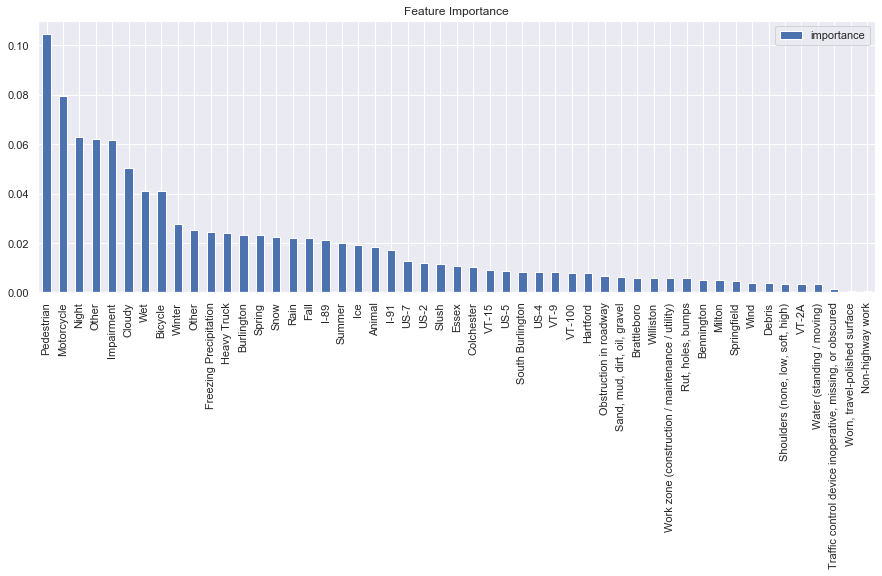

In [138]:
# Plot feature importances
feature_importances.plot(kind = 'bar',figsize=(15,5),
                         title='Feature Importance')

In [139]:
# Predict on test set
pred_y_rf = rf.predict(test_X)

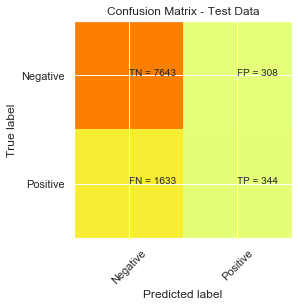

In [140]:
# Print confusion matrix
print_cm(metrics.confusion_matrix(test_y, pred_y_rf))

In [141]:
# Calculate AUC
metrics.roc_auc_score(test_y, pred_y_rf)

0.5676318729405266

In [142]:
# Calculate AUC
metrics.roc_auc_score(test_y, pred_y_rf)

0.5676318729405266

In [143]:
# Print classification report
print(metrics.classification_report(test_y, pred_y_rf))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      7951
           1       0.53      0.17      0.26      1977

    accuracy                           0.80      9928
   macro avg       0.68      0.57      0.57      9928
weighted avg       0.76      0.80      0.76      9928



We also tried Random Forest to see if we could predict whether there would be injuries in an accident. We used the converted columns from regression model.
From the importances chart, we could tell that Pedestrain, Mortorcycle and Night have the highest importances value. However, the final model has a accuracy score around 81% while the AUC is only around 57%. Therefore, he random forest model is not very reliable.

## Logistic Regression

In [144]:
#assign the dependent variable as injury, and the independent variable as the rest of the data
dv=rf_df['injury'].astype(int)
iv = rf_df.copy()
iv = iv.drop(['injury'], axis=1)

In [145]:
#split the independent and dependent variables into train and test sets
dv_train, dv_test, iv_train, iv_test = train_test_split(dv, iv, test_size = .2, random_state=123)

In [165]:
from sklearn.linear_model import LogisticRegression
#create a logisitic regression model
lr = LogisticRegression(max_iter=1000)
#fit model
fit = lr.fit(iv_train,dv_train)

In [166]:
def print_cm(cm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']] 
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
print_cm(metrics.confusion_matrix(dv_test, dv_pred))

TypeError: Expected sequence or array-like, got <class 'sklearn.linear_model._logistic.LogisticRegression'>

In [167]:
metrics.accuracy_score(dv_test, dv_pred)

TypeError: Expected sequence or array-like, got <class 'sklearn.linear_model._logistic.LogisticRegression'>

In [ ]:
metrics.roc_auc_score(dv_test, dv_pred)

In [ ]:
print(metrics.classification_report(dv_test, dv_pred))

## Gradient Boosting Machine

In [168]:
from sklearn import ensemble

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}
clf = ensemble.GradientBoostingClassifier(**original_params)
clf.fit(iv_train, dv_train)
# compute test set deviance
test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(iv_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(dv_test, dv_pred)

NameError: name 'params' is not defined

In [ ]:
import matplotlib.pyplot as plt
#create x and y values from the iv and dv training sets
x=iv_train
y=dv_train
#set optimal parameters
params = {
    'n_estimators': 200,
    'max_depth': 23,
    'learning_rate': 1,
    'criterion': 'friedman_mse'
}
#add parameters to GBC
gbc = ensemble.GradientBoostingClassifier(**params)
#fit model
gbc.fit(x, y)
#create predicted set
dv_pred = gbc.predict(iv_test)
gbc_score = gradient_boosting_classifier.score(iv_test,dv_test)
#show confusion matrix for predicted data vs test data.
print_cm(metrics.confusion_matrix(dv_test, dv_pred))

In [ ]:
#find auc score for GBC
metrics.roc_auc_score(dv_test, dv_pred)

The next three sections feature the code and image results for running tests on the Gradient Boosting Classifier model with different parameters. They are not run as code due to taking a long time to process. 

import matplotlib.pyplot as plt
#the next 3 segments are test models for different parameters. 
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': eta,
    'criterion': 'friedman_mse'
    }

    gbc = ensemble.GradientBoostingClassifier(**params)

    gbc.fit(x, y)
    train_pred = gbc.predict(iv_train)
    test_pred = gbc.predict(iv_test)
    train_results.append(metrics.roc_auc_score(dv_train, train_pred))
    test_results.append(metrics.roc_auc_score(dv_test, test_pred))
    
line1 = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
line2 = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Learning Rate')
plt.show()

In [ ]:
from IPython.display import Image
Image(filename='GBC_LearningRatesTest.jpg')

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for eta in n_estimators:
    params = {
    'n_estimators': eta,
    'max_depth': 3,
    'learning_rate': .1,
    'criterion': 'friedman_mse'
    }

    gbc = ensemble.GradientBoostingClassifier(**params)

    gbc.fit(x, y)
    train_pred = gbc.predict(iv_train)
    test_pred = gbc.predict(iv_test)
    train_results.append(metrics.roc_auc_score(dv_train, train_pred))
    test_results.append(metrics.roc_auc_score(dv_test, test_pred))
    
line1 = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
line2 = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Number of Estimators')
plt.show()

In [ ]:
Image(filename='GBC_N_Estimators.jpg')

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for eta in max_depths:
    params = {
    'n_estimators': 100,
    'max_depth': eta,
    'learning_rate': .1,
    'criterion': 'friedman_mse'
    }

    gbc = ensemble.GradientBoostingClassifier(**params)

    gbc.fit(x, y)
    train_pred = gbc.predict(iv_train)
    test_pred = gbc.predict(iv_test)
    train_results.append(metrics.roc_auc_score(dv_train, train_pred))
    test_results.append(metrics.roc_auc_score(dv_test, test_pred))
    
line1 = plt.plot(max_depths, test_results, 'r', label='Test AUC')
line2 = plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Tree Depths')
plt.show()

In [ ]:
Image(filename='GBC_TreeDepth.jpg')